# Preprocessing

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('dane.csv')
df

,Nr,Miasto,Czas dojazdu samochodem,Liczba ludności,Średnia temperatura w lipcu,Liczba deszczowych dni w lipcu,Zanieczyszczenia powietrza [**],Zanieczyszczenia powietrza
0,1,Białystok,5 godzin 6 minut,293413,19.5,10,111,5
1,2,Bydgoszcz,1 godzina 58 minut,337666,19.4,9,104,5
2,3,Gdańsk,3 godziny 46 minut,486022,18.9,10,114,5
3,4,Poznań,57 minut,546859,19.8,9,106,5
4,5,Katowice,3 godziny 34 minuty,289162,19.5,11,14,1
5,6,Kielce,4 godziny 6 minut,192498,19.4,10,44,2
6,7,Kraków,4 godziny 25 minut,800653,19.5,11,7,1
7,8,Lublin,4 godziny 45 minut,334681,17.8,9,100,5
8,9,Łódź,2 godziny 13 minut,670642,19.5,10,66,3
9,10,Opole,2 godziny 39 minut,127839,20.1,10,81,4


In [3]:
df.drop(['Nr', 'Zanieczyszczenia powietrza [**]'], axis=1, inplace=True)

In [4]:
import re

def time_to_minutes(time_str):
    matches = re.findall(r'\d+', time_str)
    if len(matches) >= 2:
        hours = int(matches[0])
        minutes = int(matches[1])
        total_minutes = hours * 60 + minutes
        return total_minutes
    else:
        return None

df['Czas dojazdu samochodem'] = df['Czas dojazdu samochodem'].apply(lambda x: time_to_minutes(x))

In [5]:
df.loc[df['Miasto'] == 'Poznań', 'Czas dojazdu samochodem'] = 57

In [6]:
for col in df.columns[1:]:
    minv = df[col].min() 
    maxv = df[col].max()
    print(col, minv, maxv)
    print(' MIN: ', df[df[col]==minv]['Miasto'].values)    
    print(' MAX: ', df[df[col]==maxv]['Miasto'].values)
    print()

Czas dojazdu samochodem 57.0 359.0
 MIN:  ['Poznań']
 MAX:  ['Rzeszów']

Liczba ludności 127839 1860281
 MIN:  ['Opole']
 MAX:  ['Warszawa']

Średnia temperatura w lipcu 17.8 20.1
 MIN:  ['Lublin']
 MAX:  ['Opole' 'Wrocław' 'Zielona Góra']

Liczba deszczowych dni w lipcu 9 12
 MIN:  ['Bydgoszcz' 'Poznań' 'Lublin' 'Warszawa' 'Wrocław' 'Zielona Góra']
 MAX:  ['Rzeszów']

Zanieczyszczenia powietrza 1 5
 MIN:  ['Katowice' 'Kraków']
 MAX:  ['Białystok' 'Bydgoszcz' 'Gdańsk' 'Poznań' 'Lublin' 'Zielona Góra']



In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Czas dojazdu samochodem,14.0,199.500000,86.767372,57.0,133.25,200.0,260.25,359.0
Liczba ludności,14.0,496546.928571,446871.634679,127839.0,221247.25,336173.5,639696.25,1860281.0
Średnia temperatura w lipcu,14.0,19.385714,0.712371,17.8,19.40,19.5,19.80,20.1
Liczba deszczowych dni w lipcu,14.0,9.857143,0.949262,9.0,9.00,10.0,10.00,12.0
Zanieczyszczenia powietrza,14.0,3.500000,1.556624,1.0,2.25,3.5,5.00,5.0


In [8]:
cost_columns = ['Czas dojazdu samochodem', 'Liczba deszczowych dni w lipcu']
df[cost_columns] = df[cost_columns] * (-1)

In [9]:
c = df.columns[1:]
df[c] = df[c].astype(float)
preferred = {}

for i, row in df.iterrows():
    if i not in preferred:
        preferred[i] = []
        
    for j, candidate in df.iterrows():
        if i != j:
            if all(df.iloc[i][c].values >= df.iloc[j][c].values):
                preferred[i].append(j)

preferred

{0: [],
 1: [5, 7],
 2: [],
 3: [0, 1, 2, 4, 5, 7, 10],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [4, 5],
 9: [],
 10: [],
 11: [],
 12: [4, 5],
 13: [9]}

# PROMETHEE
Dla każdego kryterium trzeba zdefiniować sobię f.użyteczności.
Dla uproszczenia pomnożyłem wartości w kolumnach typu koszt przez -1 -> teraz mamy wszystko typu zysk.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Czas dojazdu samochodem,14.0,-199.500000,86.767372,-359.0,-260.25,-200.0,-133.25,-57.0
Liczba ludności,14.0,496546.928571,446871.634679,127839.0,221247.25,336173.5,639696.25,1860281.0
Średnia temperatura w lipcu,14.0,19.385714,0.712371,17.8,19.40,19.5,19.80,20.1
Liczba deszczowych dni w lipcu,14.0,-9.857143,0.949262,-12.0,-10.00,-10.0,-9.00,-9.0
Zanieczyszczenia powietrza,14.0,3.500000,1.556624,1.0,2.25,3.5,5.00,5.0


In [11]:
q = [30, 50000, 1, 1, 0]
p = [60, 100000, 3, 3, 2]
w = [2, 2, 1, 2, 3]

Narazie proste f. uzytecznosci podobne jak na zrzucie <br>
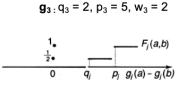

In [12]:
towns = df['Miasto']

In [13]:
df.drop(['Miasto'],axis=1,inplace=True)

In [14]:
import numpy as np

In [15]:
num_variants = df.shape[0]
num_criteria = df.shape[1]

In [ ]:
pi_array = np.zeros((num_variants, num_variants))

In [17]:
df.head(5)

,Czas dojazdu samochodem,Liczba ludności,Średnia temperatura w lipcu,Liczba deszczowych dni w lipcu,Zanieczyszczenia powietrza
0,-306.0,293413.0,19.5,-10.0,5.0
1,-118.0,337666.0,19.4,-9.0,5.0
2,-226.0,486022.0,18.9,-10.0,5.0
3,-57.0,546859.0,19.8,-9.0,5.0
4,-214.0,289162.0,19.5,-11.0,1.0


In [18]:
def calculate_g(v1, v2, q, p):
    if v1 >= v2 + p:
        return 1
    elif v1 >= v2 + q:
        return 1/2
    return 0

In [19]:
for a, row in df.iterrows():
    for b, candidate in df.iterrows():
        if a != b:
            pi = []
            for c in range(num_criteria):
                ai = df.iloc[a][c]
                bi = df.iloc[b][c]
                g = calculate_g(ai, bi, q[c], p[c])
                pi.append(g)
            pi_array[a,b] = sum([pi[i]*w[i] for i in range(len(pi))]) / sum(w)

In [20]:
pi_array

array([[0.  , 0.15, 0.15, 0.15, 0.4 , 0.5 , 0.4 , 0.2 , 0.3 , 0.35, 0.6 ,
        0.35, 0.3 , 0.35],
       [0.45, 0.  , 0.45, 0.15, 0.6 , 0.8 , 0.6 , 0.4 , 0.4 , 0.55, 0.9 ,
        0.55, 0.3 , 0.35],
       [0.55, 0.35, 0.  , 0.15, 0.6 , 0.5 , 0.5 , 0.5 , 0.3 , 0.35, 0.8 ,
        0.3 , 0.3 , 0.35],
       [0.65, 0.55, 0.55, 0.  , 0.8 , 0.8 , 0.6 , 0.6 , 0.6 , 0.65, 0.9 ,
        0.55, 0.4 , 0.55],
       [0.2 , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.25, 0.25, 0.  , 0.2 , 0.4 ,
        0.05, 0.  , 0.2 ],
       [0.2 , 0.  , 0.  , 0.  , 0.25, 0.  , 0.25, 0.15, 0.  , 0.1 , 0.3 ,
        0.05, 0.15, 0.1 ],
       [0.3 , 0.2 , 0.2 , 0.2 , 0.35, 0.2 , 0.  , 0.25, 0.2 , 0.2 , 0.5 ,
        0.05, 0.2 , 0.2 ],
       [0.25, 0.15, 0.25, 0.15, 0.4 , 0.6 , 0.4 , 0.  , 0.4 , 0.45, 0.9 ,
        0.3 , 0.3 , 0.35],
       [0.4 , 0.2 , 0.4 , 0.2 , 0.8 , 0.55, 0.6 , 0.45, 0.  , 0.2 , 0.65,
        0.3 , 0.15, 0.2 ],
       [0.2 , 0.  , 0.25, 0.  , 0.5 , 0.5 , 0.6 , 0.25, 0.15, 0.  , 0.45,
        0.2 , 0.3

In [21]:
positive_flows = []
negative_flows = []
accum_flows = []

In [22]:
for col in range(num_variants):
    negative_flows.append(sum(pi_array[col,:]))

for row in range(num_variants):
    positive_flows.append(sum(pi_array[:,row]))
    
for p, n in zip(positive_flows, negative_flows):
    accum_flows.append(p-n)

In [26]:
sum(accum_flows) # we good

2.220446049250313e-15

In [35]:
def create_ranking(towns, flow, reverse=False):
    town_flow = list(zip(towns, flow))
    sorted_town_flow = sorted(town_flow, key=lambda x: x[1], reverse=reverse)
    ranked_towns = [town for town, _ in sorted_town_flow]
    for i, town in enumerate(ranked_towns, start=1):
        print(f"{i}. {town}")

In [33]:
create_ranking(towns, positive_flows)

1. Poznań
2. Bydgoszcz
3. Zielona Góra
4. Wrocław
5. Łódź
6. Warszawa
7. Gdańsk
8. Opole
9. Lublin
10. Białystok
11. Kraków
12. Kielce
13. Katowice
14. Rzeszów


In [36]:
create_ranking(towns, negative_flows, reverse=True)

1. Poznań
2. Bydgoszcz
3. Warszawa
4. Zielona Góra
5. Gdańsk
6. Wrocław
7. Łódź
8. Lublin
9. Białystok
10. Opole
11. Kraków
12. Katowice
13. Kielce
14. Rzeszów


In [37]:
create_ranking(towns, accum_flows)

1. Poznań
2. Bydgoszcz
3. Zielona Góra
4. Warszawa
5. Wrocław
6. Gdańsk
7. Łódź
8. Lublin
9. Białystok
10. Opole
11. Kraków
12. Katowice
13. Kielce
14. Rzeszów


In [ ]:
# todo promethee I